In [1]:
import itertools
import os
import os.path as osp
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.max_rows = 200
sns.set()

In [2]:
# -----------------------------
USE_CACHE = True

RESULT_DIR = "../results/main"
SKIP_LIST = ["dev"]
# -----------------------------


cache_dir = f"{RESULT_DIR}.csv.gz"
if USE_CACHE and osp.isfile(cache_dir):
    print(f"Loaind results from cache: {cache_dir}")
    df = pd.read_csv(cache_dir)

else:
    result_dfs = []
    for i in glob(osp.join(RESULT_DIR, "*")):
        name = osp.split(i)[1]
        if name in SKIP_LIST:
            continue

        for j in glob(osp.join(i, "*")):
            runid = osp.split(j)[1]
            path = osp.join(j, "final_scores.csv")
            # print(j, os.listdir(j))
            if not osp.isfile(path):
                continue

            print(f"Loading {path:<200}", end="\r", flush=True)
            new_df = pd.read_csv(path, index_col=0)
            new_df["name"] = name
            new_df["runid"] = runid
            result_dfs.append(new_df)
    df = pd.concat(result_dfs).reset_index(drop=True)

df

Loaind results from cache: ../results/main.csv.gz


,split,task_id,score_type,score_value,name,runid
0,train,MONDO:0002245,APOP,5.929194,ComPPIHumanInt-DISEASES-LabelProp,run_3
1,train,MONDO:0021129,APOP,6.365293,ComPPIHumanInt-DISEASES-LabelProp,run_3
2,train,MONDO:0000066,APOP,6.808900,ComPPIHumanInt-DISEASES-LabelProp,run_3
3,train,MONDO:0005039,APOP,2.964916,ComPPIHumanInt-DISEASES-LabelProp,run_3
4,train,MONDO:0002320,APOP,3.867794,ComPPIHumanInt-DISEASES-LabelProp,run_3
...,...,...,...,...,...,...
11517952,test,GO:0007160,AUROC,0.818182,OmniPath-GOBP-LogReg+Walklets,run_0
11517953,test,GO:0001227,AUROC,0.582231,OmniPath-GOBP-LogReg+Walklets,run_0
11517954,test,GO:0003714,AUROC,0.534060,OmniPath-GOBP-LogReg+Walklets,run_0
11517955,test,GO:0007601,AUROC,0.599359,OmniPath-GOBP-LogReg+Walklets,run_0


In [3]:
summary_df = (
    df
    .query("split == 'test' & score_type == 'APOP'")
    .groupby("name", as_index=False)
    .mean(numeric_only=True)
)
summary_df["score_value_std"] = (
    df
    .query("split == 'test' & score_type == 'APOP'")
    .groupby(["runid", "score_type", "name"], as_index=False)
    .mean(numeric_only=True)
    .groupby("name", as_index=False)
    .std(numeric_only=True)
    .fillna(0.0)
)["score_value"]
summary_df["score_value_formatted"] = (
    summary_df[["score_value", "score_value_std"]]
    .agg(lambda x: " ± ".join(f"{i:.03f}" for i in x), axis=1)
)

# -------------
# summary_df["name"] = summary_df["name"].str.replace("-BoT", "+BoT")
summary_df = summary_df.loc[~summary_df["name"].str.contains("-BoT")]
# -------------

summary_df[["network", "label", "model"]] = summary_df["name"].str.split("-", expand=True)
summary_df["basemodel"] = summary_df["model"].str.split("+", expand=True)[0]
summary_df

,name,score_value,score_value_std,score_value_formatted,network,label,model,basemodel
0,BioGRID-DISEASES-GAT,0.946002,0.289236,0.946 ± 0.289,BioGRID,DISEASES,GAT,GAT
1,BioGRID-DISEASES-GAT+Adj,1.289534,0.320223,1.290 ± 0.320,BioGRID,DISEASES,GAT+Adj,GAT
2,BioGRID-DISEASES-GAT+AdjEmbBag,0.645221,0.049270,0.645 ± 0.049,BioGRID,DISEASES,GAT+AdjEmbBag,GAT
3,BioGRID-DISEASES-GAT+BoT,1.608970,0.047668,1.609 ± 0.048,BioGRID,DISEASES,GAT+BoT,GAT
4,BioGRID-DISEASES-GAT+CS+OneHotLogDeg,1.393080,0.027179,1.393 ± 0.027,BioGRID,DISEASES,GAT+CS+OneHotLogDeg,GAT
...,...,...,...,...,...,...,...,...
1861,STRING-GOBP-LogReg+LapEigMap,3.680634,0.003836,3.681 ± 0.004,STRING,GOBP,LogReg+LapEigMap,LogReg
1862,STRING-GOBP-LogReg+Node2vec,3.460509,0.019739,3.461 ± 0.020,STRING,GOBP,LogReg+Node2vec,LogReg
1863,STRING-GOBP-LogReg+SVD,3.539084,0.003081,3.539 ± 0.003,STRING,GOBP,LogReg+SVD,LogReg
1864,STRING-GOBP-LogReg+Walklets,3.291781,0.075006,3.292 ± 0.075,STRING,GOBP,LogReg+Walklets,LogReg


## Ablation studies: node features, C&S, label reuse

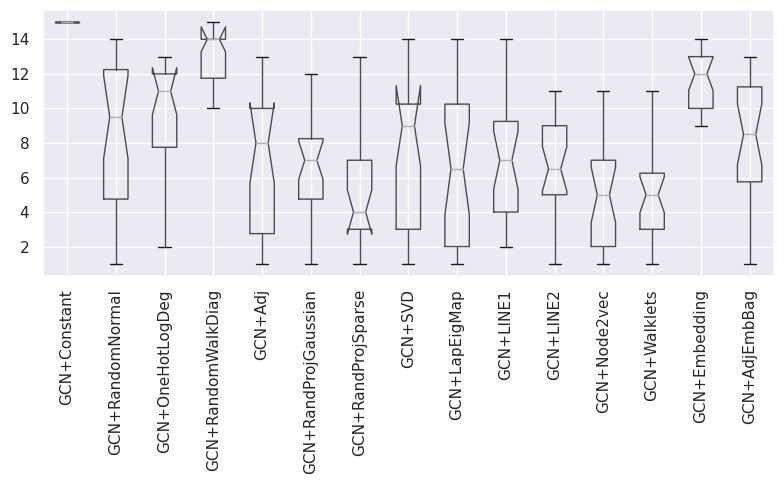

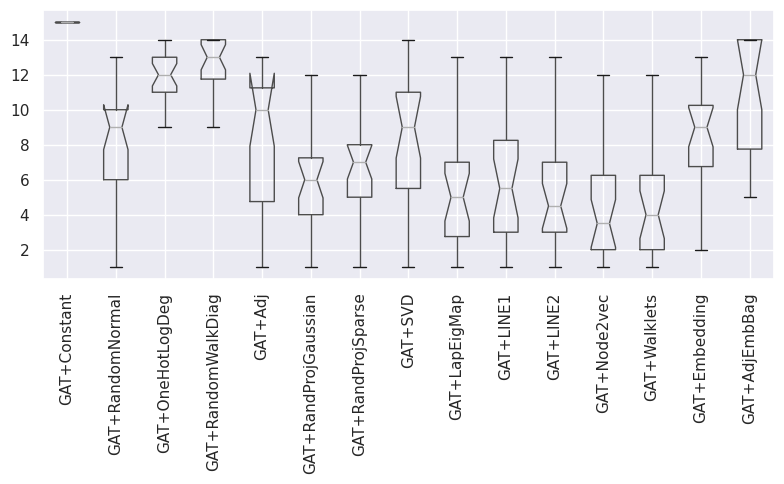

In [4]:
# GCN and GAT ablations with different node feature constructions
networks = [
    "BioGRID",
    "HumanNet",
    "ComPPIHumanInt",
    "BioPlex",
    "HuRI",
    "OmniPath",
    "ProteomeHD",
    "SIGNOR",
]
labels = [
    "GOBP",
    "DisGeNET",
    "DISEASES",
]

basemodels = [
    "GCN",
    "GAT",
]
features = [
    "Constant",
    "RandomNormal",
    "OneHotLogDeg",
    "RandomWalkDiag",
    "Adj",
    "RandProjGaussian",
    "RandProjSparse",
    "SVD",
    "LapEigMap",
    "LINE1",
    "LINE2",
    "Node2vec",
    "Walklets",
    "Embedding",
    "AdjEmbBag",
]

for basemodel in basemodels:
    models = [f"{basemodel}+{feature}" for feature in features]

    # GNN feature performace ranks across datasets (lower the better)
    plt.figure(figsize=(8, 5))
    (
        summary_df[
            summary_df["network"].isin(networks)
            & summary_df["label"].isin(labels)
            & summary_df["model"].isin(models)
        ]
        .pivot_table("score_value", "model", ["network", "label"]).loc[models]
        .rank(axis=0, ascending=False).T
        .boxplot(notch=True, showfliers=False)
    )
    plt.xticks(rotation=90)
    plt.tight_layout()
    # plt.savefig(f"gnn_feature_ranks_{basemodel}.pdf", bbox_inches="tight")  # uncomment to save
    plt.show()

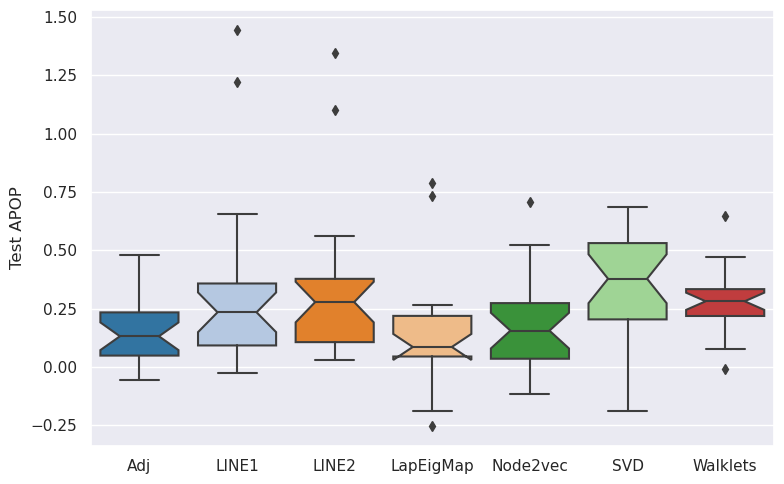

In [5]:
# C&S ablation for logistic regression methods
networks = [
    "BioGRID",
    "HumanNet",
    "ComPPIHumanInt",
    "BioPlex",
    "HuRI",
    "OmniPath",
    "ProteomeHD",
    "SIGNOR",
]

labels = [
    "GOBP",
    "DisGeNET",
    "DISEASES",
]

basemodels = [
    "LogReg+Adj",
    "LogReg+LapEigMap",
    "LogReg+SVD",
    "LogReg+LINE1",
    "LogReg+LINE2",
    "LogReg+Node2vec",
    "LogReg+Walklets",
]
ablation = "+CS"
ablated_models_dict = {basemodel + ablation: basemodel for basemodel in basemodels}

summary_df_base = (
    summary_df[summary_df["model"].isin(basemodels)]
    .set_index(["network", "label", "model"])[["score_value"]]
)

summary_df_abl = summary_df[summary_df["model"].isin(ablated_models_dict.keys())].copy()
summary_df_abl["model"] = summary_df_abl["model"].apply(lambda x: ablated_models_dict.get(x) or x)
summary_df_abl = summary_df_abl.set_index(["network", "label", "model"])[["score_value"]]

abl_perf_diff_df = (summary_df_abl - summary_df_base).copy().reset_index()
abl_perf_diff_df["model"] = abl_perf_diff_df["model"].str.split("+", expand=True)[1]

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=abl_perf_diff_df,
    x="model",
    y="score_value",
    notch=True,
    palette="tab20",
)
plt.xlabel("")
plt.ylabel("Test APOP")
plt.tight_layout()
# plt.savefig("logreg_cs_ablation.pdf", bbox_inches="tight")  # uncomment to save
plt.show()

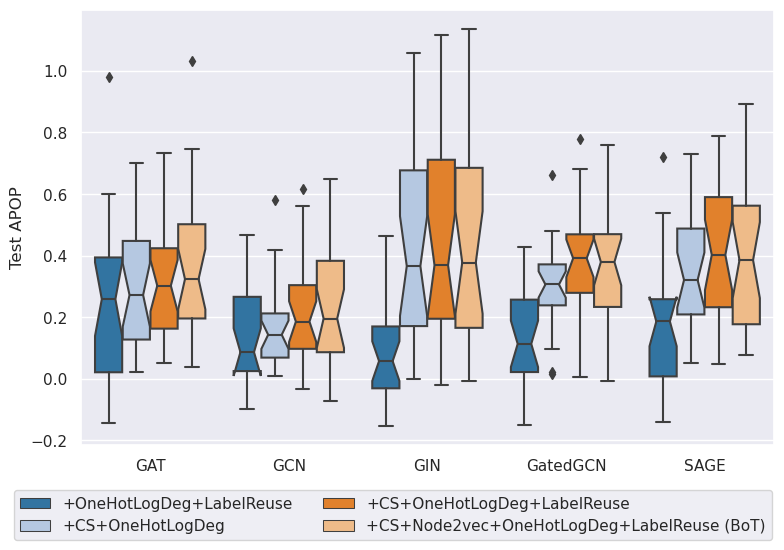

In [6]:
# GNN tricks ablation
networks = [
    "BioGRID",
    "HumanNet",
    "ComPPIHumanInt",
    "BioPlex",
    "HuRI",
    "OmniPath",
    "ProteomeHD",
    "SIGNOR",
]
labels = [
    "GOBP",
    "DisGeNET",
    "DISEASES",
]

basemodels = [
    "GCN",
    "SAGE",
    "GIN",
    "GAT",
    "GatedGCN",
]
ablations = [
    "+OneHotLogDeg+LabelReuse",
    "+CS+OneHotLogDeg",
    "+CS+OneHotLogDeg+LabelReuse",
    "+BoT",
]

abl_perf_diff_dfs = []
summary_df_base = (
    summary_df[summary_df["model"].isin(basemodels)]
    .set_index(["network", "label", "basemodel"])[["score_value"]]
)
for ablation in ablations:
    ablated_models = [basemodel + ablation for basemodel in basemodels]
    summary_df_abl = (
        summary_df[summary_df["model"].isin(ablated_models)]
        .set_index(["network", "label", "basemodel"])[["score_value"]]
    )
    abl_perf_diff_dfs.append((summary_df_abl - summary_df_base).copy().reset_index())
    abl_perf_diff_dfs[-1]["ablation"] = ablation
    
abl_perf_diff_df = pd.concat(abl_perf_diff_dfs)
abl_perf_diff_df["ablation"] = abl_perf_diff_df["ablation"].str.replace(
    "+BoT",
    "+CS+Node2vec+OneHotLogDeg+LabelReuse (BoT)",
    regex=False,
)
abl_perf_diff_df


plt.figure(figsize=(8, 5))
sns.boxplot(
    data=abl_perf_diff_df,
    x="basemodel",
    y="score_value",
    hue="ablation",
    notch=True,
    palette="tab20",
)
plt.xlabel("")
plt.ylabel("Test APOP")
plt.tight_layout()
plt.legend(bbox_to_anchor=(0.45, -0.16), loc="center", ncols=2)
# plt.savefig("gnn_tricks_ablation.pdf", bbox_inches="tight")  # uncomment to save
plt.show()

## Performance correlation and difference between methods across tasks

In [7]:
# ----------------
selected_models = {
    "GCN",
    "GAT",
    "LogReg+Adj",
    "LogReg+Node2vec",
    "LogReg+LapEigMap",
    "LabelProp",
}
# -----------------

sub_df = (
    df[~df["name"].str.contains("-BoT")]
    .query("split == 'test' & score_type == 'APOP'")
    .groupby(["name", "task_id"], as_index=False)
    .mean(numeric_only=True)
    .sort_values("score_value", ascending=False)
)

sub_df[["network", "label", "model"]] = sub_df["name"].str.split("-", expand=True)
sub_df = (
    sub_df
    .loc[sub_df["model"].isin(selected_models)]
    .sort_values(["network", "label", "model"])
    .reset_index()
)

sub_df

,index,name,task_id,score_value,network,label,model
0,0,BioGRID-DISEASES-GAT,MONDO:0000066,3.720390,BioGRID,DISEASES,GAT
1,38,BioGRID-DISEASES-GAT,MONDO:0003004,3.583151,BioGRID,DISEASES,GAT
2,123,BioGRID-DISEASES-GAT,MONDO:0021181,3.339038,BioGRID,DISEASES,GAT
3,119,BioGRID-DISEASES-GAT,MONDO:0021094,3.287829,BioGRID,DISEASES,GAT
4,41,BioGRID-DISEASES-GAT,MONDO:0003664,2.970912,BioGRID,DISEASES,GAT
...,...,...,...,...,...,...,...
27887,256517,STRING-GOBP-LogReg+Node2vec,GO:0043065,0.437576,STRING,GOBP,LogReg+Node2vec
27888,256499,STRING-GOBP-LogReg+Node2vec,GO:0030335,0.418468,STRING,GOBP,LogReg+Node2vec
27889,256498,STRING-GOBP-LogReg+Node2vec,GO:0030308,0.418421,STRING,GOBP,LogReg+Node2vec
27890,256481,STRING-GOBP-LogReg+Node2vec,GO:0008283,0.390250,STRING,GOBP,LogReg+Node2vec


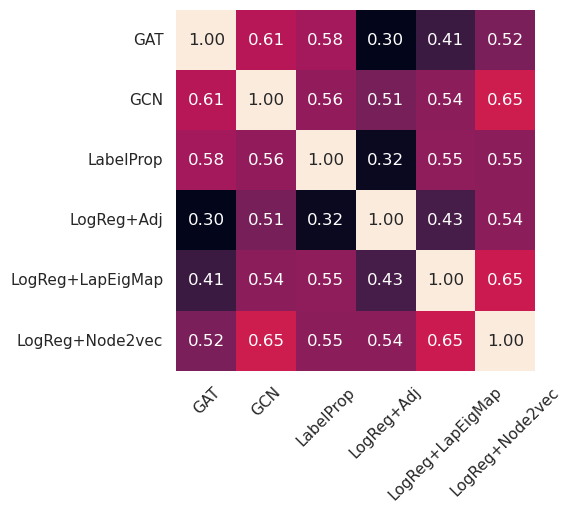

In [8]:
# ------------
network = "BioGRID"
label = "DisGeNET"
# ------------

plt.figure(figsize=(6, 5.5))
sns.heatmap(
    data=(
        sub_df
        .query("network == @network & label == @label")
        .pivot_table(values="score_value", index="task_id", columns="model")
        .corr()
    ),
    cbar=False,
    annot=True,
    fmt=".2f",
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlabel("")
plt.ylabel("")
# plt.savefig(f"perf_corr_{network}_{label}.pdf", bbox_inches="tight")
plt.show()

In [9]:
# -------------
model1 = "GAT"
model2 = "LogReg+Adj"
# -------------

diff_df = (
    sub_df
    .query("network == @network & label == @label & (model == @model1 | model == @model2)")
    .pivot_table(values="score_value", index="task_id", columns="model")
)

diff_df["Diff"] = diff_df[model1] - diff_df[model2]
diff_df = diff_df.sort_values("Diff", ascending=False)

diff_df

model,GAT,LogReg+Adj,Diff
task_id,,,
MONDO:0002289,2.159592,0.148614,2.010977
MONDO:0001703,2.176753,0.230342,1.946411
MONDO:0001926,1.543357,-0.335886,1.879243
MONDO:0005552,1.507348,-0.174574,1.681922
MONDO:0018470,1.272835,-0.347488,1.620323
...,...,...,...
MONDO:0020018,0.698698,4.486894,-3.788196
MONDO:0019743,0.772793,4.875797,-4.103003
MONDO:0024757,0.315683,4.442540,-4.126856


## Print tables for manuscript

In [10]:
PRINT_LATEX_TABLES = False  # change to True to enable printing

In [11]:
# Print baseline performance table
if PRINT_LATEX_TABLES:
    networks = [
        "BioGRID",
        "HumanNet",
        "ComPPIHumanInt",
        "BioPlex",
        "HuRI",
        "OmniPath",
        "ProteomeHD",
        "SIGNOR",
    ]

    labels = [
        "GOBP",
        "DisGeNET",
        "DISEASES",
    ]

    models = [
        "GCN",
        "SAGE",
        "GIN",
        "GAT",
        "GatedGCN",
        "LabelProp",
        "LogReg+Adj",
        "LogReg+LapEigMap",
        "LogReg+SVD",
        "LogReg+LINE1",
        "LogReg+LINE2",
        "LogReg+Node2vec",
        "LogReg+Walklets",
    ]


    print(
        summary_df[
            summary_df["network"].isin(networks)
            & summary_df["label"].isin(labels)
            & summary_df["model"].isin(models)
        ].pivot_table("score_value_formatted", ["network", "model"], "label", aggfunc=lambda x: x)
        .reindex(list(itertools.product(networks, models)))
        .style.to_latex()
    )

In [12]:
# Print GCN and GAT node feature ablation table
if PRINT_LATEX_TABLES:
    networks = [
        "BioGRID",
        "HumanNet",
        "ComPPIHumanInt",
        "BioPlex",
        "HuRI",
        "OmniPath",
        "ProteomeHD",
        "SIGNOR",
    ]

    labels = [
        "GOBP",
        "DisGeNET",
        "DISEASES",
    ]

    models = [
        f"{model}+{feature}"
        for model, feature in itertools.product(
            [
                "GCN",
                "GAT",
            ],
            [
                "Constant",
                "RandomNormal",
                "OneHotLogDeg",
                "RandomWalkDiag",
                "Adj",
                "RandProjGaussian",
                "RandProjSparse",
                "SVD",
                "LapEigMap",
                "LINE1",
                "LINE2",
                "Node2vec",
                "Walklets",
                "Embedding",
                "AdjEmbBag",
            ],
        )
    ]

    print(
        summary_df[
            summary_df["network"].isin(networks)
            & summary_df["label"].isin(labels)
            & summary_df["model"].isin(models)
        ].pivot_table("score_value_formatted", ["network", "basemodel", "model"], "label", aggfunc=lambda x: x)
        .reindex([(i, j.split("+")[0], j) for i, j in itertools.product(networks, models)])
        .style.to_latex()
    )

In [13]:
# Print SOTA reference table
if PRINT_LATEX_TABLES:
    tmp_df = (
        summary_df[
            summary_df["network"].isin(networks)
            & summary_df["model"].isin(models)
        ]
        .pivot_table("score_value_formatted", "label", ["network", "basemodel"], aggfunc="max")
        .sort_index().T.copy()
    )

    for network in tmp_df.index.get_level_values("network").unique():
        ind = tmp_df.index.get_level_values("network") == network
        sub_tmp_df = tmp_df[ind]
        for label in ["GOBP", "DisGeNET", "DISEASES"]:
            mean_scores = np.array([i.split(" ")[0] for i in sub_tmp_df[label].tolist()])
            sorted_index = mean_scores.argsort()[::-1]

            for i, j in enumerate([r"\first", r"\second", r"\third"]):
                idx = sub_tmp_df.iloc[sorted_index[i]].name
                tmp_df.loc[idx, label] = j + "{" + tmp_df.loc[idx, label] + "}"

    ordered_networks = [
        "BioGRID",
        "HumanNet",
        "ComPPIHumanInt",
        "BioPlex",
        "HuRI",
        "OmniPath",
        "ProteomeHD",
        "SIGNOR",
    ]
    ordered_models = models = [
        "LabelProp",
        "LogReg",
        "GCN",
        "SAGE",
        "GIN",
        "GAT",
        "GatedGCN",
    ]
    ordered_index = list(itertools.product(ordered_networks, ordered_models))

    # tmp_df.reindex(ordered_index)
    print(tmp_df.reindex(ordered_index).style.to_latex())